In [73]:
import pandas as pd 
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf #yahoo finance stock data
import datetime
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import accuracy_score,classification_report

from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor

stock="GOOG"

In [74]:
min=yf.download(tickers=stock,period="3d", interval="1m")
fift_min=yf.download(tickers=stock,period="31d", interval="15m")
hour=yf.download(tickers=stock,period="122d", interval="1h")
daily=yf.download(tickers=stock,period="765d", interval="1d")
week=yf.download(tickers=stock,period="3650d", interval="1wk")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [75]:
def Prepare_dataset(df):
    from sklearn.model_selection import train_test_split

    period=14

    typ_price=(df.Close + df.High+df.Low)/3
    mf=typ_price*df.Volume

    pos_flow=[]
    neg_flow=[]

    for i in range(0,len(typ_price)):
        if typ_price[i]>typ_price[i-1]:
            pos_flow.append(mf[i-1])
            neg_flow.append(0)
        elif typ_price[i]<typ_price[i-1]:
            pos_flow.append(0)
            neg_flow.append(mf[i-1])
        else:
            pos_flow.append(0)
            neg_flow.append(0)
        
    pos_mf=[]
    neg_mf=[]

    for i in range(period-1,len(pos_flow)):
        pos_mf.append(sum(pos_flow[i+1-period:i+1]))

    for i in range(period-1,len(neg_flow)):
        neg_mf.append(sum(neg_flow[i+1-period:i+1]))

    mf_ratio=np.array(pos_mf)/np.array(neg_mf)

    mfi=100-100/(1+mf_ratio)
    df=df.iloc[13:,:]

    df["MFI"]=mfi

    y=df.iloc[:-1,:]["Adj Close"].shift(-1)
    y.fillna(method='ffill', inplace=True)
    X=df.iloc[:-1,:].fillna(method='ffill')

    return train_test_split(X, y, test_size=0.4, random_state=0)

def Get_signal(data,high,low):
    buy_signal=[]
    sell_signal=[]

    for i in range(len(data["MFI"])):
        if data["MFI"][i]>high:
            buy_signal.append(np.nan)
            sell_signal.append(data["Close"][i])
        elif data["MFI"][i]<low:
            buy_signal.append(data["Close"][i])
            sell_signal.append(np.nan) 
        else:
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
    return(buy_signal,sell_signal)
    
def Rmse(y,y_pred):
    return np.sqrt(((y_pred - y) ** 2).mean())

In [76]:
X_tr_m,X_te_m,y_tr_m,y_te_m=Prepare_dataset(min)
X_tr_f,X_te_f,y_tr_f,y_te_f=Prepare_dataset(fift_min)
X_tr_h,X_te_h,y_tr_h,y_te_h=Prepare_dataset(hour)
X_tr_d,X_te_d,y_tr_d,y_te_d=Prepare_dataset(daily)
X_tr_w,X_te_w,y_tr_w,y_te_w=Prepare_dataset(week)

In [77]:
from sklearn.linear_model import LinearRegression

In [83]:
linreg = LinearRegression().fit(X_tr_m, y_tr_m)
linreg_preds=linreg.predict(X_te_m)

elastic=ElasticNet().fit(X_tr_m, y_tr_m)
elastic_preds=elastic.predict(X_te_m)

rf=RandomForestRegressor(n_estimators=100,max_depth=12,random_state=0).fit(X_tr_m, y_tr_m)
rf_preds=rf.predict(X_te_m)

result_m=pd.DataFrame({"True":y_te_m,"Linreg":linreg_preds,"Elastic":elastic_preds,"RandomForest":rf_preds})


In [84]:
Rmse(y_te_m,linreg_preds),Rmse(y_te_m,elastic_preds),Rmse(y_te_m,rf_preds)

(1.8244439282717444, 1.5750015584072699, 1.1689291324352076)

In [85]:
linreg = LinearRegression().fit(X_tr_d, y_tr_d)
linreg_preds=linreg.predict(X_te_d)

elastic=ElasticNet().fit(X_tr_d, y_tr_d)
elastic_preds=elastic.predict(X_te_d)

rf=RandomForestRegressor(n_estimators=100,max_depth=12,random_state=0).fit(X_tr_d, y_tr_d)
rf_preds=rf.predict(X_te_d)

result_d=pd.DataFrame({"True":y_te_d,"Linreg":linreg_preds,"Elastic":elastic_preds,"RandomForest":rf_preds})


In [86]:
Rmse(y_te_d,linreg_preds),Rmse(y_te_d,elastic_preds),Rmse(y_te_d,rf_preds)

(22.323779535779877, 22.320079290574586, 24.092428275771933)

<AxesSubplot:xlabel='Date'>

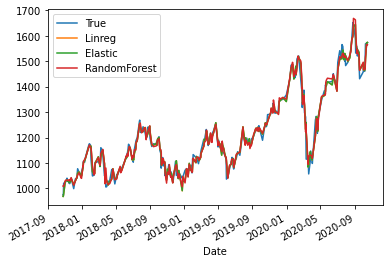

In [87]:
result.plot()
